In [35]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image 
import numpy as np
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
from numpy.random import randn
from numpy.random import randint
from numpy import zeros
from numpy.random import random
from numpy import vstack
import numpy as np
from numpy.random import rand 
from keras.datasets.mnist import load_data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def prepare_real_samples():
  (trainX, trainy), (testX, testy) = load_data()
  X = np.expand_dims(trainX,axis=-1)
  X = X.astype("float32")
  X = X / 255.0
  return X

In [0]:
#plt.imshow(trainX[2], cmap="gray_r")

In [0]:
def discriminator_model(input_shape = (28,28,1)):
  model = Sequential()
  model.add(Conv2D(64, (3,3) ,strides=(2,2), padding='same',input_shape=input_shape))
  model.add(LeakyReLU(alpha=0.3))
  model.add(Dropout(0.4))
  model.add(Conv2D(64, (3,3) ,strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.3))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(1, activation="sigmoid"))
  optimizer = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])
  return model

In [7]:
model = discriminator_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)             

In [0]:
def generate_real_samples(dataset, n_samples):
  idx = randint(0,dataset.shape[0],n_samples)
  X = dataset[idx]
  y = np.ones((n_samples,1))
  return X,y

In [0]:
def generate_fake_samples(n_samples):
  X = rand(28*28*n_samples)
  X = X.reshape((n_samples,28,28,1))
  y = np.zeros((n_samples,1))
  return X,y

In [0]:
def train_discriminator(model,dataset,n_iter = 100,n_batches = 256):
  half_batch = int(n_batches/2)
  for i in range(n_iter):
    X_real, y_real = generate_real_samples(dataset,half_batch)
    _,real_acc = model.train_on_batch(X_real,y_real)
    X_fake, y_fake = generate_fake_samples(half_batch)
    _, fake_acc = model.train_on_batch(X_fake, y_fake)
    print("At iteration " + str(i)+ " Real accuracy " + str(real_acc) + " fake accuracy "+ str(fake_acc))


In [11]:
model = discriminator_model()
dataset = prepare_real_samples()
train_discriminator(model,dataset)


11493376/11490434 [==============================] - 0s 0us/step
At iteration 0 Real accuracy 0.8125 fake accuracy 0.109375
At iteration 1 Real accuracy 0.8671875 fake accuracy 0.3359375
At iteration 2 Real accuracy 0.8046875 fake accuracy 0.5
At iteration 3 Real accuracy 0.8046875 fake accuracy 0.8359375
At iteration 4 Real accuracy 0.796875 fake accuracy 0.859375
At iteration 5 Real accuracy 0.7578125 fake accuracy 0.9765625
At iteration 6 Real accuracy 0.7421875 fake accuracy 0.9921875
At iteration 7 Real accuracy 0.8046875 fake accuracy 1.0
At iteration 8 Real accuracy 0.75 fake accuracy 1.0
At iteration 9 Real accuracy 0.703125 fake accuracy 1.0
At iteration 10 Real accuracy 0.6953125 fake accuracy 1.0
At iteration 11 Real accuracy 0.6640625 fake accuracy 1.0
At iteration 12 Real accuracy 0.7265625 fake accuracy 1.0
At iteration 13 Real accuracy 0.7421875 fake accuracy 1.0
At iteration 14 Real accuracy 0.8125 fake accuracy 1.0
At iteration 15 Real accuracy 0.8203125 fake accuracy 

Generator model

In [0]:
def generator_model(latent_dim = 100):
  model = Sequential()
  model.add(Dense(128*7*7,input_dim=latent_dim))
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Reshape((7,7,128)))
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(1, (7,7), activation="sigmoid", padding="same"))
  return model

In [0]:
def generate_latent_points(latent_dim,n_samples):
  x_input = randn(latent_dim * n_samples)
  x_input = x_input.reshape(n_samples,latent_dim)
  return x_input

In [0]:
def generate_fake_samples(g_model,latent_dim,n_samples):
  x_input = generate_latent_points(latent_dim,n_samples)
  X = g_model.predict(x_input)
  y = zeros((n_samples,1))
  return X, y

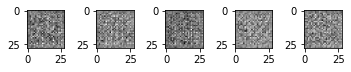

In [15]:
latent_dim = 100
model = generator_model(latent_dim)
n_samples = 5
X,_ = generate_fake_samples(model,latent_dim,n_samples)
for i in range(n_samples):
  plt.subplot(5,5,1+i)
  plt.imshow(X[i,:,:,0], cmap="gray_r")
plt.show()

In [0]:
def define_gan(generator, discriminator):
  generator.trainable = False
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss="binary_crossentropy",optimizer=opt)
  return model

In [0]:
def train_gan(generator, discriminator, gan_model, latent_dim , n_epochs, n_batch, dataset):
  batches_per_epoch = int(dataset.shape[0]/n_batch)
  half_batch = int(n_batch/2)
  for i in range(n_epochs):
    for j in range(batches_per_epoch):
      x_real,y_real = generate_real_samples(dataset,half_batch)
      x_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
      X, y = vstack((x_real, x_fake)), vstack((y_real, y_fake))
      d_loss,_ = discriminator.train_on_batch(X,y)
      x_gan = generate_latent_points(latent_dim, n_batch)
      y_gan = np.ones((n_batch,1))
      g_loss = gan_model.train_on_batch(x_gan, y_gan)
      print(i,j,batches_per_epoch,d_loss,g_loss)
    if (i+1) % 1000 == 0 :
      summarize_performance(i, generator, discriminator, dataset, latent_dim)



In [0]:
def summarize_performance(epoch,generator,discriminator,dataset,latent_dim,n_samples=100):
  x_real,y_real = generate_real_samples(dataset,n_samples)
  _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
  x_fake, y_fake = generate_fake_samples(generator, latent_dim, n_samples)
  _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
  print("Real accuracy is " + str(acc_real)+ " and fake accuracy is "+ str(acc_fake))
  save_plot(x_fake, epoch)
  filename = "generator_model_%03d.h5" % (epoch + 1) 
  g_model.save(filename)



In [0]:
def save_plot(examples, epoch, n= 10):
  for i in range(n*n):
    plt.subplot(n,n,1+i)
    plt.axis('off')
    plt.imshow(examples[i,:,:,0], cmap="gray_r")
  filename = "generated_plot_e%03d.png" % (epoch+1)
  plt.savefig(filename)
  plt.close()

In [0]:
latent_dim = 100
discriminator = discriminator_model()
generator = generator_model(latent_dim)
gan_model = define_gan(generator, discriminator)
dataset = prepare_real_samples()
train_gan(generator, discriminator, gan_model, latent_dim, 100,256,dataset)

0 0 234 0.6760099 0.7506194
0 1 234 0.6655116 0.7502436
0 2 234 0.6725731 0.7455438
0 3 234 0.66900694 0.73708206
0 4 234 0.6638751 0.7409481
0 5 234 0.66696763 0.7430123
0 6 234 0.66421455 0.73227894
0 7 234 0.6601521 0.7231033
0 8 234 0.6617844 0.7229701
0 9 234 0.6559933 0.7136355
0 10 234 0.65926373 0.7118132
0 11 234 0.6594441 0.71860397
0 12 234 0.652828 0.70495236
0 13 234 0.65367806 0.7062582
0 14 234 0.6484059 0.6991115
0 15 234 0.6465175 0.70877934
0 16 234 0.645687 0.7040861
0 17 234 0.6460919 0.70589507
0 18 234 0.64239717 0.7012815
0 19 234 0.6454124 0.697827
0 20 234 0.6374066 0.7003682
0 21 234 0.6360375 0.704842
0 22 234 0.6345615 0.70015097
0 23 234 0.6308059 0.70302486
0 24 234 0.63011837 0.698634
0 25 234 0.63041997 0.6983695
0 26 234 0.6236254 0.6947801
0 27 234 0.62489414 0.700042
0 28 234 0.61693 0.69145346
0 29 234 0.625706 0.6947233
0 30 234 0.61904037 0.69123626
0 31 234 0.6188481 0.6959817
0 32 234 0.61661625 0.70034534
0 33 234 0.6089826 0.70612276
0 34 234 0